# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [19]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [20]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, train_loop, test_loop
from common_utils import split_dataset, EarlyStopper, generate_cv_folds, preprocess_dataset

3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [21]:
def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):

    # YOUR CODE HERE
    # Create datasets and data loaders for training and testing
    train_dataset = CustomDataset(X_train_scaled, y_train2)
    test_dataset = CustomDataset(X_val_scaled, y_val2)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize optimizer, loss function, and early stopper
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters["learning_rate"])
    loss_fn = nn.BCELoss()
    early_stopper = EarlyStopper(patience=parameters["patience"], min_delta=0)
    
    for epoch in range(parameters["num_epochs"]):

        model.train()
        start = time.time()
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_losses, train_accuracies = train_loop(train_dataloader, model, loss_fn, optimizer)
        end = time.time()

        model.eval()
        test_losses, test_accuracies = test_loop(test_dataloader, model, loss_fn)
        
        if early_stopper.early_stop(test_losses): 
            print("Early Stop!")
            times = end - start

            return train_accuracies, train_losses, test_accuracies, test_losses, times

    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [22]:
def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):
    # YOUR CODE HERE
    # Scale data and generate cross folds
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds(parameters, X_train, y_train)

    cross_validation_accuracies = []
    cross_validation_times = []

    # Iterate over different numbers of hidden neurons
    for num_hidden in parameters["num_neurons"]:

        # Get test and train data for each batch size
        x_train_list = X_train_scaled_dict[num_hidden]
        x_val_list = X_val_scaled_dict[num_hidden]
        y_train_list = y_train_dict[num_hidden]
        y_val_list = y_val_dict[num_hidden]
        fold_times = []
        fold_accuracies = []

        for fold in range(parameters["cv_fold"]):
            x_train = x_train_list[fold]
            x_val = x_val_list[fold]
            y_train = y_train_list[fold]
            y_val = y_val_list[fold]

            # Create and train the model with the current number of hidden neurons
            model = MLP(no_features=parameters["no_features"], no_hidden=num_hidden, no_labels=parameters["no_labels"])

            train_accuracies, train_losses, test_accuracies, test_losses, times = train(model, x_train, y_train,
                                                                                        x_val, y_val, batch_size)

            fold_times.append(times)
            fold_accuracies.append(test_accuracies)

        cross_validation_accuracies.append(fold_accuracies)
        cross_validation_times.append(fold_times)

    cross_validation_accuracies = np.mean(np.array(cross_validation_accuracies), axis=1)
    cross_validation_times = np.mean(np.array(cross_validation_times), axis=1)

    return cross_validation_accuracies, cross_validation_times

'''
optimal_bs = 0. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE

# Prepare dataset
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()

X_train, y_train, X_test, y_test = split_dataset(df, ['filename','label'], test_size=0.3, random_state=0)
X_train = pd.concat([X_train, X_test])
y_train = np.concatenate((y_train, y_test), axis=0)

parameters = {"num_neurons":[64, 128, 256],
             "cv_fold": 5,
              "no_features": 77,
              "no_labels": 1,
              "learning_rate": 0.001,
              "batch_size": [128],
              "num_epochs": 100,
              "patience": 3}

num_neurons = [64, 128, 256]
optimal_bs = 256
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train.to_numpy(),
                                                                                  y_train,
                                                                                  parameters,
                                                                                  'num_neurons', optimal_bs)

Epoch 1
-------------------------------
loss: 0.691422  [  256/ 9645]
Train Error: 
 Accuracy: 53.5%, Avg loss: 0.689213 

Test Error: 
 Accuracy: 56.2%, Avg loss: 0.683466 

Epoch 2
-------------------------------
loss: 0.671018  [  256/ 9645]
Train Error: 
 Accuracy: 57.4%, Avg loss: 0.679937 

Test Error: 
 Accuracy: 58.5%, Avg loss: 0.672853 

Epoch 3
-------------------------------
loss: 0.678994  [  256/ 9645]
Train Error: 
 Accuracy: 58.7%, Avg loss: 0.670175 

Test Error: 
 Accuracy: 60.0%, Avg loss: 0.665757 

Epoch 4
-------------------------------
loss: 0.676680  [  256/ 9645]
Train Error: 
 Accuracy: 60.5%, Avg loss: 0.659920 

Test Error: 
 Accuracy: 61.4%, Avg loss: 0.656406 

Epoch 5
-------------------------------
loss: 0.637191  [  256/ 9645]
Train Error: 
 Accuracy: 60.9%, Avg loss: 0.654056 

Test Error: 
 Accuracy: 62.1%, Avg loss: 0.651577 

Epoch 6
-------------------------------
loss: 0.638804  [  256/ 9645]
Train Error: 
 Accuracy: 62.8%, Avg loss: 0.641833 

Te

4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

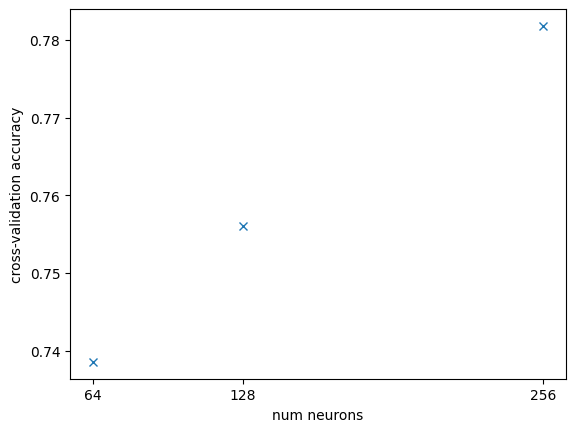

In [23]:
# YOUR CODE HERE
num_neurons = parameters["num_neurons"]
plt.figure(1)
plt.plot(num_neurons, cross_validation_accuracies, marker = 'x', linestyle = 'None')
plt.xticks(num_neurons)
plt.xlabel('num neurons')
plt.ylabel('cross-validation accuracy')
plt.show()

5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [24]:
optimal_neurons = 256
reason = "Selected because it had the highest cross-validation accuracy on last epoch."
# YOUR CODE HERE
df = pd.DataFrame({'Number of neurons': num_neurons,
                   'Last Epoch Time': cross_validation_times
                  })

df

,Number of neurons,Last Epoch Time
0,64,0.134216
1,128,0.182509
2,256,0.314089


6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

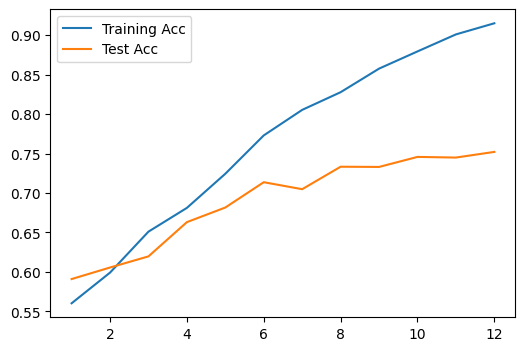

In [25]:
fig = plt.figure(figsize=(6,4))
plt.plot(range(1,len(train_acc)+1),train_acc, label='Training Acc')
plt.plot(range(1,len(test_acc)+1),test_acc,label='Test Acc')
plt.legend()
plt.show()